# 2.1 Pythonによる分析の準備

In [41]:
# ライブラリ
import numpy as np
import pandas as pd
pd.set_option("display.unicode.east_asian_width", True)
pd.set_option("display.precision", 3)
%precision 3

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install japanize-matplotlib
import japanize_matplotlib
japanize_matplotlib.japanize()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, brier_score_loss, roc_curve, plot_roc_curve, auc)
from sklearn.calibration import calibration_curve

# 2.2 予測値の作成

In [42]:
# 予測の対象となるデータを読み込む
data = pd.read_csv("https://raw.githubusercontent.com/logics-of-blue/book-decision-analysis-and-forecast/main/book-data/5-2-sample-data.csv", index_col = 0)
data.head(3)

,y,X_1,X_2,X_3,X_4
0,1.0,2.952,1.057,0.622,2.558
1,0.0,-0.953,-2.613,0.083,-0.826
2,1.0,-0.680,0.513,-0.450,-0.590


In [43]:
# 応答変数と説明変数を分ける
y = data.iloc[:, 0]
X = data.iloc[:, 1:]

In [44]:
# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)
print("訓練データ：", X_train.shape)
print("テストデータ：", X_test.shape)

訓練データ： (6000, 4)
テストデータ： (4000, 4)


In [45]:
# ロジスティック回帰モデルによる予測
mod_logistic = LogisticRegression().fit(X_train, y_train)

In [46]:
# カテゴリー予測
category_pred = mod_logistic.predict(X_test)
category_pred

array([0., 1., 1., ..., 0., 1., 1.])

In [47]:
# 確率予測
prob_pred = mod_logistic.predict_proba(X_test)[:, 1]
prob_pred

array([0.183, 1.   , 0.837, ..., 0.02 , 0.752, 0.92 ])

# 2.3 カテゴリー予測の評価

In [48]:
# カテゴリー予測の評価
print(f"的中率：{accuracy_score(y_test, category_pred):.3g}")
print(f"適合率：{precision_score(y_test, category_pred):.3g}")
print(f"再現率：{recall_score(y_test, category_pred):.3g}")
print(f"F値：{f1_score(y_test, category_pred):.3g}")

的中率：0.876
適合率：0.879
再現率：0.868
F値：0.874


In [49]:
# 分割表（度数）
confusion_matrix(y_test, category_pred)

array([[1800,  235],
       [ 259, 1706]])

In [50]:
# 自然の状態に対する条件付き分布：P(f|θ)
conditional_state = confusion_matrix(y_test, category_pred, normalize = "true")
conditional_state

array([[0.885, 0.115],
       [0.132, 0.868]])

In [51]:
# 真陽性率と偽陽性率
print(f"TPR(真陽性率)：{conditional_state[1, 1]:.3g}")
print(f"FPR(偽陽性率)：{conditional_state[0, 1]:.3g}")

TPR(真陽性率)：0.868
FPR(偽陽性率)：0.115


# 2.4 ブライアスコアによる確率予測の評価

In [52]:
# 確率予測の評価

# ブライアスコア
print(f"ブライアスコア（定義通り計算）：{sum((prob_pred - y_test) ** 2) / len(y_test):.3g}")
BS = brier_score_loss(y_test, prob_pred)
print(f"ブライアスコア（sklearn）：{BS:.3g}")

ブライアスコア（定義通り計算）：0.0894
ブライアスコア（sklearn）：0.0894


In [53]:
# ブライアスキルスコア

# 平均的な問題発生率
p_naive = sum(y_test) / len(y_test)

# BS_naive
BS_naive = brier_score_loss(y_test, np.repeat(p_naive, len(y_test)))

# ブライアスキルスコア
print(f"ブライアスキルスコア：{(BS_naive - BS) / BS_naive:.3g}")

ブライアスキルスコア：0.642


# 2.5 信頼度曲線による確率予測の評価

In [54]:
# 信頼度曲線

# 確率を11区分に区切って集計値を得る
prob_true_class, prob_pred_class = calibration_curve(y_test, prob_pred, n_bins = 11)
print(f"prob_pred_class: {prob_pred_class}")
print(f"prob_true_class: {prob_true_class}")

prob_pred_class: [0.029 0.134 0.225 0.316 0.409 0.498 0.596 0.683 0.774 0.869 0.977]
prob_true_class: [0.04  0.132 0.195 0.268 0.362 0.478 0.55  0.67  0.67  0.867 0.981]


Text(0, 0.5, '実際の確率')

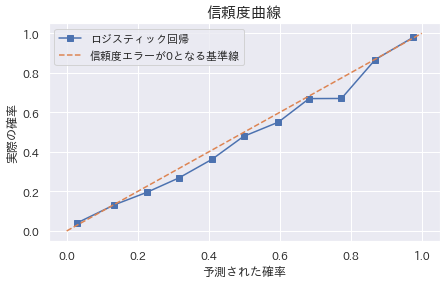

In [55]:
# 可視化
fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(prob_pred_class, prob_true_class, marker = "s", label = "ロジスティック回帰")
ax.plot([0, 1], [0, 1], linestyle = "--", label = "信頼度エラーが0となる基準線")
ax.legend(loc = "best")
ax.set_title("信頼度曲線", fontsize = 15)
ax.set_xlabel("予測された確率")
ax.set_ylabel("実際の確率")

# 2.6 Sharpnessによる確率予測の評価

Text(0, 0.5, '度数')

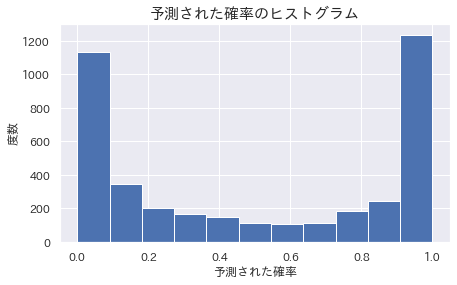

In [56]:
# Sharpnessによる確率予測の評価
fig, ax = plt.subplots(figsize = (7, 4))
ax.hist(prob_pred, bins = 11)
ax.set_title("予測された確率のヒストグラム", fontsize = 15)
ax.set_xlabel("予測された確率")
ax.set_ylabel("度数")

# 2.7 確率予測をカテゴリー予測に変換する

In [57]:
# 確率予測をカテゴリー予測に変換する関数
def prob_to_category(prob_pred, threshold):
  return (prob_pred >= threshold).astype(int)

In [58]:
# ロジスティック回帰によるカテゴリー予測はthreshold=0.5になってる
all(category_pred == prob_to_category(prob_pred, 0.5))

True

In [60]:
# 確率予測から分割表を得る関数
def prob_to_mat(prob_pred, threshold, y_true, print_acc = True):

  # 確率予測をカテゴリー予測に変換
  category_pred = prob_to_category(prob_pred, threshold)

  # 必要に応じて指標をプリント
  if(print_acc):
    conditional_state = confusion_matrix(y_true, category_pred, normalize = "true")
    print(f"的中率：{accuracy_score(y_test, category_pred):.3g}")
    print(f"TPR(真陽性率)：{conditional_state[1, 1]:.3g}")
    print(f"FPR(偽陽性率)：{conditional_state[0, 1]:.3g}")
  
  # DataFrameに変換した分割表を返す
  joint_forecast_state = pd.DataFrame(
      confusion_matrix(y_true, category_pred, normalize = "all"), 
      columns = ["予測－問題なし", "予測－問題あり"], 
      index = ["問題なし", "問題あり"])
  
  return joint_forecast_state

In [61]:
# 動作確認
prob_to_mat(prob_pred, 0.5, y_test)

的中率：0.876
TPR(真陽性率)：0.868
FPR(偽陽性率)：0.115


,予測－問題なし,予測－問題あり
問題なし,0.450,0.059
問題あり,0.065,0.426


# 2.8 ROC曲線とAUCによる確率予測の評価

In [64]:
# thresholdと評価指標の関係
tmp = prob_to_mat(prob_pred, 0.1, y_test)
print(tmp)
tmp2 = prob_to_mat(prob_pred, 0.9, y_test)
print(tmp2)

的中率：0.76
TPR(真陽性率)：0.975
FPR(偽陽性率)：0.448
          予測－問題なし  予測－問題あり
問題なし           0.281           0.228
問題あり           0.013           0.479
的中率：0.812
TPR(真陽性率)：0.632
FPR(偽陽性率)：0.0133
          予測－問題なし  予測－問題あり
問題なし           0.502           0.007
問題あり           0.181           0.310


In [66]:
# 真陽性率と偽陽性率，閾値を取得
fpr, tpr, threshold = roc_curve(y_test, prob_pred)

Text(0, 0.5, '真陽性率')

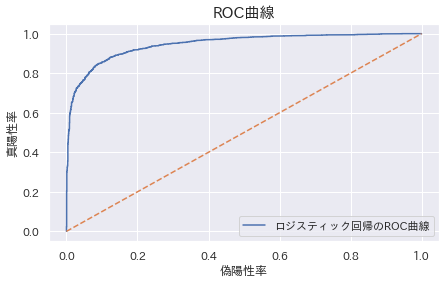

In [69]:
# ROC曲線可視化
fig, ax = plt.subplots(figsize = (7, 4))
ax.step(fpr, tpr, label = "ロジスティック回帰のROC曲線")
ax.plot([0, 1], [0, 1], linestyle = "--")
ax.legend()
ax.set_title("ROC曲線", fontsize = 15)
ax.set_xlabel("偽陽性率")
ax.set_ylabel("真陽性率")

In [70]:
# AUC
print(f"AUC:{auc(fpr, tpr):.3g}")

AUC:0.947


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'ROC curve')

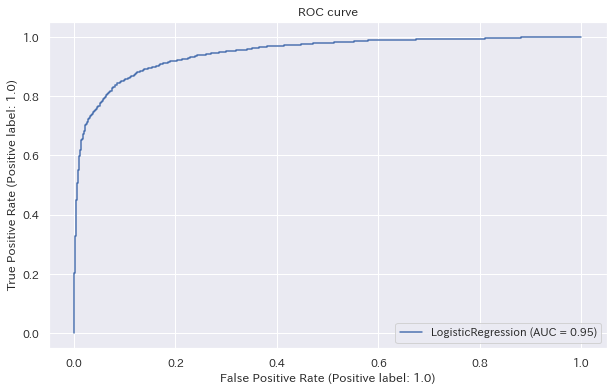

In [77]:
# plot_roc_curve関数
mod = LogisticRegression()
mod.fit(X_train, y_train)
fig, ax = plt.subplots(figsize = (10, 6))
plot_roc_curve(mod, X_test, y_test, ax = ax)
ax.set_title("ROC curve")

# 2.9 意思決定にかかわる要素の整理

In [78]:
# 利得行列
payoff = pd.DataFrame({
    "対策なし": [1000, 0], 
    "対策あり": [200, 200]
})
payoff.index = ["問題なし", "問題あり"]
payoff

,対策なし,対策あり
問題なし,1000,200
問題あり,0,200


In [79]:
# 最大値をとるインデックスを取得する関数
def argmax_list(series):
  return list(series[series == series.max()].index)

In [80]:
# 期待金額最大化に基づく意思決定を行う関数
def max_emv(probs, payoff_table):
  emv = payoff_table.mul(probs, axis = 0).sum()
  max_emv = emv.max()
  a_star = argmax_list(emv)
  return pd.Series([a_star, max_emv], index = ["選択肢", "期待金額"])

# 2.10 予測を使わないときの期待金額

In [81]:
# カテゴリー予測と自然の状態の同時分布
joint_forecast_state = prob_to_mat(prob_pred, 0.5, y_test, print_acc = False)
joint_forecast_state

,予測－問題なし,予測－問題あり
問題なし,0.450,0.059
問題あり,0.065,0.426


In [82]:
# 自然の状態の周辺分布
marginal_state = joint_forecast_state.sum(axis = 1)
marginal_state

問題なし    0.509
問題あり    0.491
dtype: float64

In [83]:
# 期待金額を最大にする選択肢
naive_decision = max_emv(marginal_state, payoff)
naive_decision

選択肢      [対策なし]
期待金額        508.75
dtype: object

# 2.11 カテゴリー予測を使うときの期待金額

In [84]:
# カテゴリー予測の周辺分布
marginal_forecast = joint_forecast_state.sum(axis = 0)
marginal_forecast

予測－問題なし    0.515
予測－問題あり    0.485
dtype: float64

In [85]:
# 予測に対する条件付き分布：P(θ|f)
conditional_forecast = joint_forecast_state.div(marginal_forecast, axis = 1)
conditional_forecast

,予測－問題なし,予測－問題あり
問題なし,0.874,0.121
問題あり,0.126,0.879


In [86]:
# 予測ごとの，期待金額を最大にする選択肢とそのときの期待金額
info_decision = conditional_forecast.apply(max_emv, axis = 0, payoff_table = payoff)
info_decision

,予測－問題なし,予測－問題あり
選択肢,[対策なし],[対策あり]
期待金額,874.211,200.0


In [88]:
# 予測の周辺分布で期待値をとり，予測を使うときの期待金額を得る
info_decision.loc["期待金額"].mul(marginal_forecast).sum()

547.050

In [91]:
# 同時分布を使っても同じ結果を得る
joint_forecast_state.apply(max_emv, axis = 0, payoff_table = payoff).loc["期待金額"].sum()

547.050

# 2.12 確率予測を使うときの期待金額

In [92]:
# 閾値をgivenとして確率予測をカテゴリー予測に変換し，その結果に基づいて意思決定を行ったときの最大の期待金額を返す関数
def prob_pred_emv(prob_pred, threshold, y_true, payoff_table, print_acc = False):

  # 確率予測をカテゴリー予測に変換して同時分布を得る
  joint_forecast_state = prob_to_mat(prob_pred, threshold, y_true, print_acc)

  # 期待金額の最大値を返す
  emv = joint_forecast_state.apply(max_emv, axis = 0, payoff_table = payoff_table).loc["期待金額"].sum()
  return emv

In [93]:
# 動作確認
prob_pred_emv(prob_pred, 0.5, y_test, payoff)

547.050

In [94]:
# threshold = 0.8のとき
prob_pred_emv(prob_pred, 0.8, y_test, payoff)

566.600

In [95]:
# 予測を使わないときのEMV
emv_naive = naive_decision.loc["期待金額"]

# 予測を使うときのEMV
emv_category = prob_pred_emv(prob_pred, 0.5, y_test, payoff)
emv_prob = prob_pred_emv(prob_pred, 0.8, y_test, payoff)

# 予測の価値
evsi_category = emv_category - emv_naive
evsi_prob = emv_prob - emv_naive
print(f"カテゴリー予測の価値：{evsi_category:.3g}")
print(f"確率予測の価値：{evsi_prob:.3g}")

カテゴリー予測の価値：38.3
確率予測の価値：57.8


# 2.13 確率予測における決定方式のチューニング

In [96]:
# 閾値を0から1まで変化させる
threshold_array = np.arange(0, 1.01, 0.01)

# 各閾値でEMVを計算
emv_array = np.zeros(len(threshold_array))
for i in range(len(threshold_array)):
  emv_array[i] = prob_pred_emv(prob_pred, threshold_array[i], y_test, payoff)

In [98]:
# データフレーム化
prob_pred_emv_df = pd.DataFrame({
    "EMV": emv_array, 
    "threshold": threshold_array
})
prob_pred_emv_df

,EMV,threshold
0,508.75,0.00
1,508.75,0.01
2,508.75,0.02
3,508.75,0.03
4,508.75,0.04
...,...,...
96,553.35,0.96
97,548.80,0.97
98,543.60,0.98
99,536.05,0.99


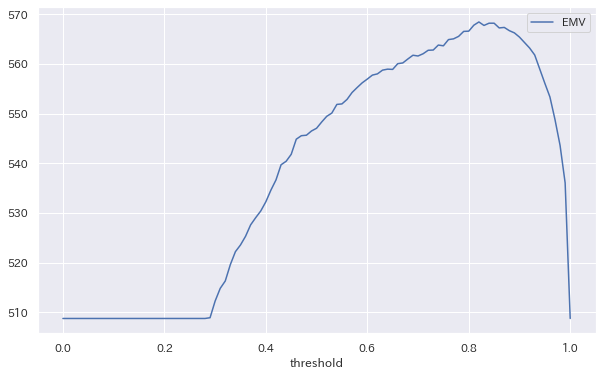

In [111]:
# 可視化
fig, ax = plt.subplots(figsize = (10, 6))
prob_pred_emv_df.plot(x = "threshold", y = "EMV", ax = ax)
#ax.plot(prob_pred_emv_df["threshold"], prob_pred_emv_df["EMV"])
#ax.set_xlabel("threshold")
#ax.set_ylabel("EMV")

In [108]:
# 期待金額が最大になる閾値
prob_pred_emv_df.iloc[prob_pred_emv_df["EMV"].idxmax()]

EMV          568.45
threshold      0.82
Name: 82, dtype: float64

In [109]:
# 閾値を変更したときの予測の価値
emv_prob_best = prob_pred_emv_df["EMV"].max()
evsi_prob_best = emv_prob_best - emv_naive
print(f"閾値を変更したときの予測の価値：{evsi_prob_best:.3g}")

閾値を変更したときの予測の価値：59.7
